# Fine Food Review

Assignment for Swisscom interview<br>
Ludovic Herbelin, 2020

**Goals : Predict review score from the text of the review.**

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')
from tqdm.notebook import tqdm
import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludovic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludovic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading data

In [58]:
DATASET_PATH = 'Reviews.csv'

dataset = pd.read_csv(DATASET_PATH, nrows=10000)

print(len(dataset))

10000


In [107]:
df = dataset.copy()
df = df.drop(columns=['Id','ProductId', 'UserId', 'ProfileName', 'Time', 'Text'])
feature_column = 'Summary'

df.dropna(inplace=True)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary
0,1,1,5,Good Quality Dog Food
1,0,0,1,Not as Advertised
2,1,1,4,"""Delight"" says it all"
3,3,3,2,Cough Medicine
4,0,0,5,Great taffy


### Dataset preprocessing

In [159]:
X = df.loc[:, df.columns != 'Score']
Y = df['Score']

In [160]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.8

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(Y_train)}, test set size : {len(Y_test)}")

Train size : 8000, test set size : 2000


### Text preprocessing

In [161]:
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

stem = SnowballStemmer('english')
stopwords = set(stopwords.words('english'))  

def __stem_word__(word):
    return stem.stem(word)

def __tokenize_text__(text):
    return word_tokenize(text)

def preproces_text(text):
    words = __tokenize_text__(text)
    # set words to lowercase and remove punctuation
    words = [word.lower() for word in words if word.isalpha()]
    words = [__stem_word__(word) for word in words]
    words = list(filter(lambda w: w not in stopwords, words))
    
    return ' '.join(words)

print(preproces_text(df[feature_column][0]))

good qualiti dog food


### Model

In [163]:
from sklearn.pipeline import Pipeline

# TODO : fix pandas warning
X_train.loc[:, [feature_column + '_cleanup']] = X_train[feature_column].apply(preproces_text)
feature_column_cleanu = feature_column + '_cleanup'

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reg', LogisticRegression(max_iter=10000)),
])

text_clf.fit(X_train[feature_column], Y_train)

e:\documents\school\swisscom_assignment\finefoodreview\venv\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
e:\documents\school\swisscom_assignment\finefoodreview\venv\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('reg', LogisticRegression(max_iter=10000))])

In [154]:
from sklearn.metrics import accuracy_score
def test_compute_metrics(model, X, Y):
    y_pred = model.predict(X)
    acc = accuracy_score(Y, y_pred)
    return {'accuracy':acc}

In [155]:
train_metrics = test_compute_metrics(text_clf, X_train[feature_column], Y_train)

train_metrics = {'train_' + k:v for k,v in train_metrics.items()}

### Test set

In [156]:
test_metrics = test_compute_metrics(text_clf, X_test[feature_column], Y_test)

test_metrics = {'test_' + k:v for k,v in test_metrics.items()}

### Print the most important words at each score

In [185]:
TOP_N_WORDS = 5

def get_top_words_score(clf_pipeline, TOP_N):
    feature_names = clf_pipeline['vect'].get_feature_names()
    top_words = {}
    for i, score in enumerate(set(Y_test)):
        # get the TOP_N sorted (desc) by their coefficient of importance in the classifier
        top = np.argsort(clf_pipeline['reg'].coef_[i])[-TOP_N_WORDS:]
        top_words[score] = list(feature_names[word_id] for word_id in top)
        
    return top_words

top_words = get_top_words_score(text_clf, TOP_N = TOP_N_WORDS)
for score, words in top_words.items():
    print(f"[Score = {score}] : {words}")

{1: ['never', 'wast', 'horribl', 'aw', 'worst'], 2: ['wo', 'weak', 'disappoint', 'salti', 'poor'], 3: ['somewhat', 'unremark', 'decent', 'ok', 'okay'], 4: ['great', 'ice', 'satisfi', 'instant', 'nice'], 5: ['delici', 'excel', 'love', 'best', 'great']}


### Plot metrics

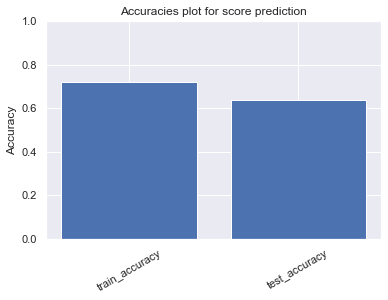

In [182]:
sns.set_theme()

def plot_bar(results_dict, title, ylabel):
    plt.bar(results_dict.keys(), results_dict.values())
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=30)
    plt.ylim((0,1))
    plt.show()

metrics_dict = train_metrics
metrics_dict.update(test_metrics)
plot_bar(metrics_dict, "Accuracies plot for score prediction", "Accuracy")